In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import warnings
import time

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

In [45]:
df = pd.read_csv(r"C:\MIDS\ADS_505_Applied_Data_Science_for_Business\ADS-505_Final_Project_Team_4\data\german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### Feature Creation

In [46]:
# Create categorical feature for age
interval = (18, 25, 35, 60, 120)
# (18, 25) represents the interval for "Students" (ages 18 to 25).
# (25, 35) represents the interval for "Young" adults (ages 26 to 35).
# (35, 60) represents the interval for "Adults" (ages 36 to 60).
# (60, 120) represents the interval for "Seniors" (ages 61 to 120).
cats = ['Student', 'Young Adult', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

### Summary Statistics

In [12]:
def analyze_data(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

        if df[name].dtype in ['float64', 'int64']:
            summary.loc[summary['Name'] == name, 'Skewness'] = round(stats.skew(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Kurtosis'] = round(stats.kurtosis(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Min'] = df[name].min()
            summary.loc[summary['Name'] == name, 'Mean'] = df[name].mean()
            summary.loc[summary['Name'] == name, 'Median'] = df[name].median()
            summary.loc[summary['Name'] == name, 'Max'] = df[name].max()
            summary.loc[summary['Name'] == name, 'Std'] = df[name].std()

            # Outlier detection using IQR
            Q1 = df[name].quantile(0.25)
            Q3 = df[name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[name] < Q1 - 1.5 * IQR) | (df[name] > Q3 + 1.5 * IQR)]
            summary.loc[summary['Name'] == name, 'Outliers'] = len(outliers)

    return summary

# Analyze the dataset and store the summary
summary = analyze_data(df)
summary

Dataset Shape: (1000, 11)


,Name,dtypes,Missing,Uniques,First Value,Entropy,Skewness,Kurtosis,Min,Mean,Median,Max,Std,Outliers
0,Age,int64,0,53,67,5.27,1.02,0.59,19.0,35.546,33.0,75.0,11.375469,23.0
1,Sex,object,0,2,male,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Job,int64,0,4,2,1.41,-0.37,0.49,0.0,1.904,2.0,3.0,0.653614,370.0
3,Housing,object,0,3,own,1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Saving accounts,object,183,4,NaN,1.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Checking account,object,394,3,little,1.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Credit amount,int64,0,921,1169,9.80,1.95,4.27,250.0,3271.258,2319.5,18424.0,2822.736876,72.0
7,Duration,int64,0,33,6,3.76,1.09,0.91,4.0,20.903,18.0,72.0,12.058814,70.0
8,Purpose,object,0,8,radio/TV,2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Risk,object,0,2,good,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Target Variable Distribution 

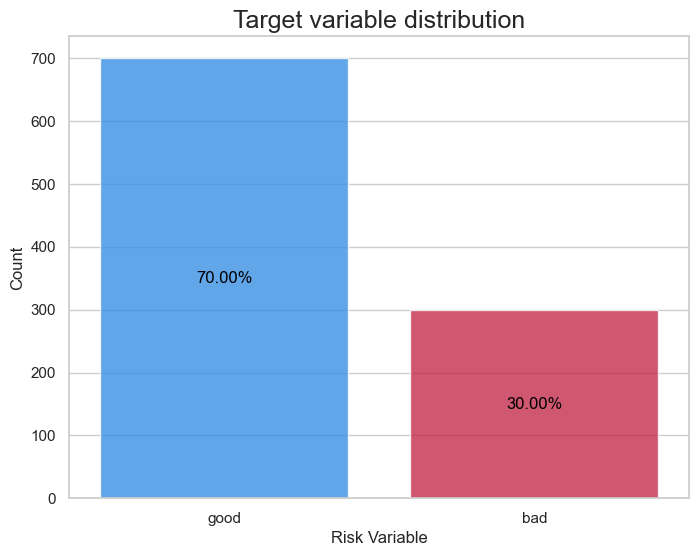

In [13]:
# Calculate the counts for 'good' and 'bad' credit
counts = df['Risk'].value_counts()

# Calculate the percentages
total_count = counts.sum()
percentages = (counts / total_count) * 100

# Create a bar chart with percentages in the center of each bar using Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=counts.index, y=counts.values, palette=['dodgerblue', 'crimson'], alpha=0.8)
plt.xlabel('Risk Variable')
plt.ylabel('Count')
plt.title('Target variable distribution', fontsize=18)

# Add percentages at the center of each bar
for bar, percentage in zip(ax.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percentage:.2f}%', 
             ha='center', va='center', fontsize=12, color='black')

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'target_variable_distribution.png')
plt.savefig(plot_filename)

plt.show()

#### Distribution of Numerical Features vs Target

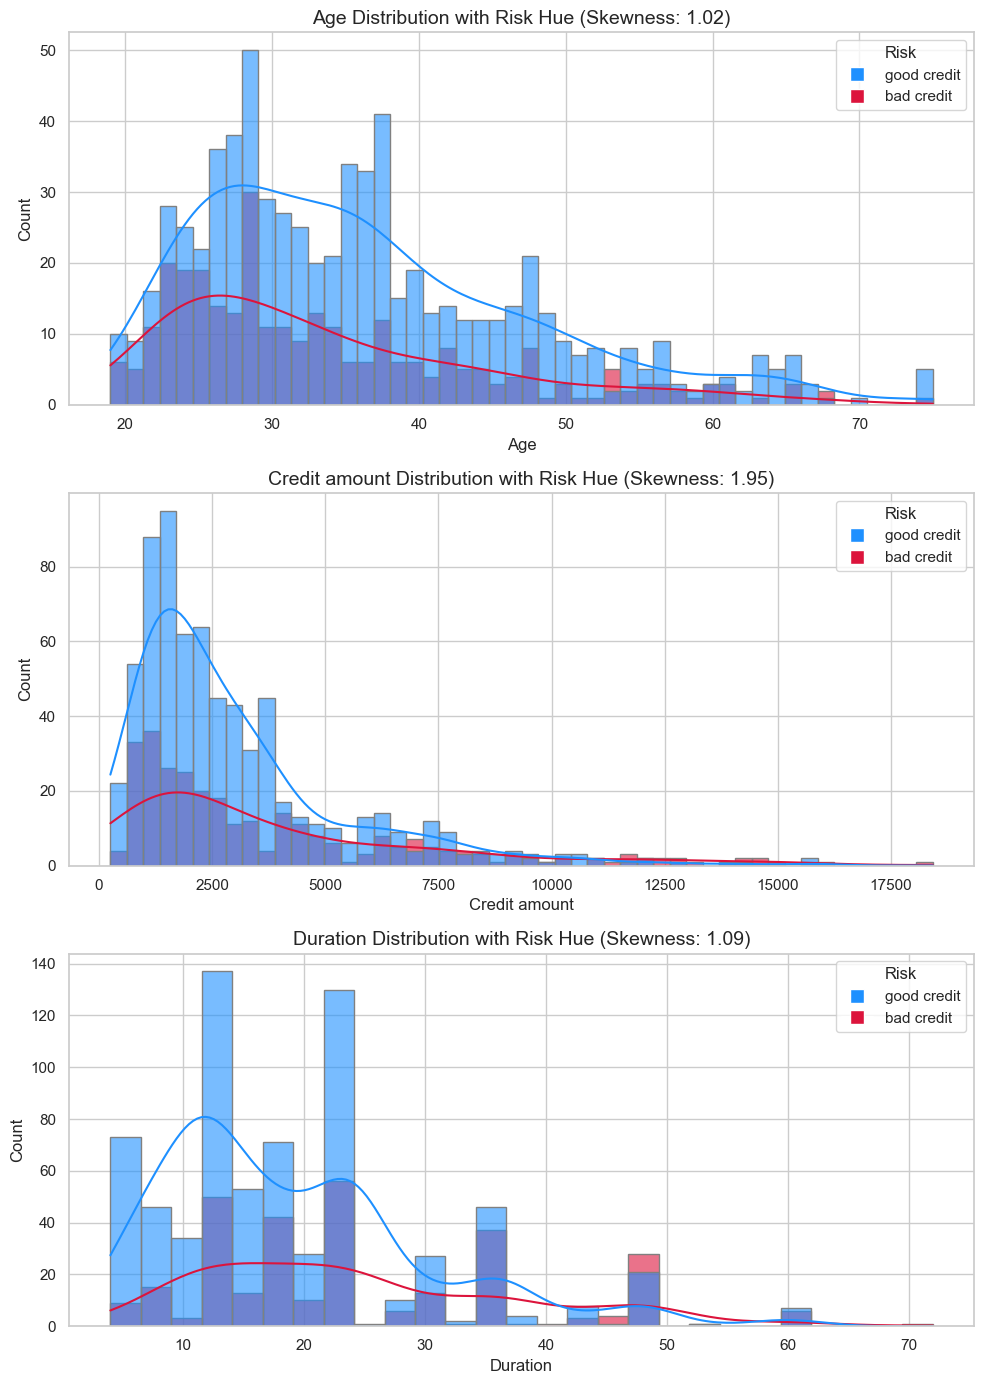

In [14]:
# Create a 3x1 grid of histograms with different bin counts
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Columns to plot and their corresponding bin counts
columns_to_plot = ['Age', 'Credit amount', 'Duration']
bin_counts = [50, 50, 27]  # Adjust the bin counts as needed

# Loop through columns and create histograms with specified bin counts
for i, (column, bins) in enumerate(zip(columns_to_plot, bin_counts)):
    ax = axes[i]
    
    # Calculate skewness
    skewness = df[column].skew()
    
    sns.histplot(data=df, x=column, hue='Risk', alpha=0.6, element='bars', bins=bins, 
                 palette={'good': 'dodgerblue', 'bad': 'crimson'}, edgecolor='grey', kde=True, legend=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    
    # Add skewness to the title
    ax.set_title(f'{column} Distribution with Risk Hue (Skewness: {skewness:.2f})', fontsize=14)
    sns.set(style="whitegrid")
    legend_labels = ['good credit', 'bad credit']
    legend_colors = ['dodgerblue', 'crimson']
    legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(handles=legend_handles, title='Risk')

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'age_creditamount_duration_distributions.png')
plt.savefig(plot_filename)

plt.show()

#### Distribution of Categorical Features vs Target

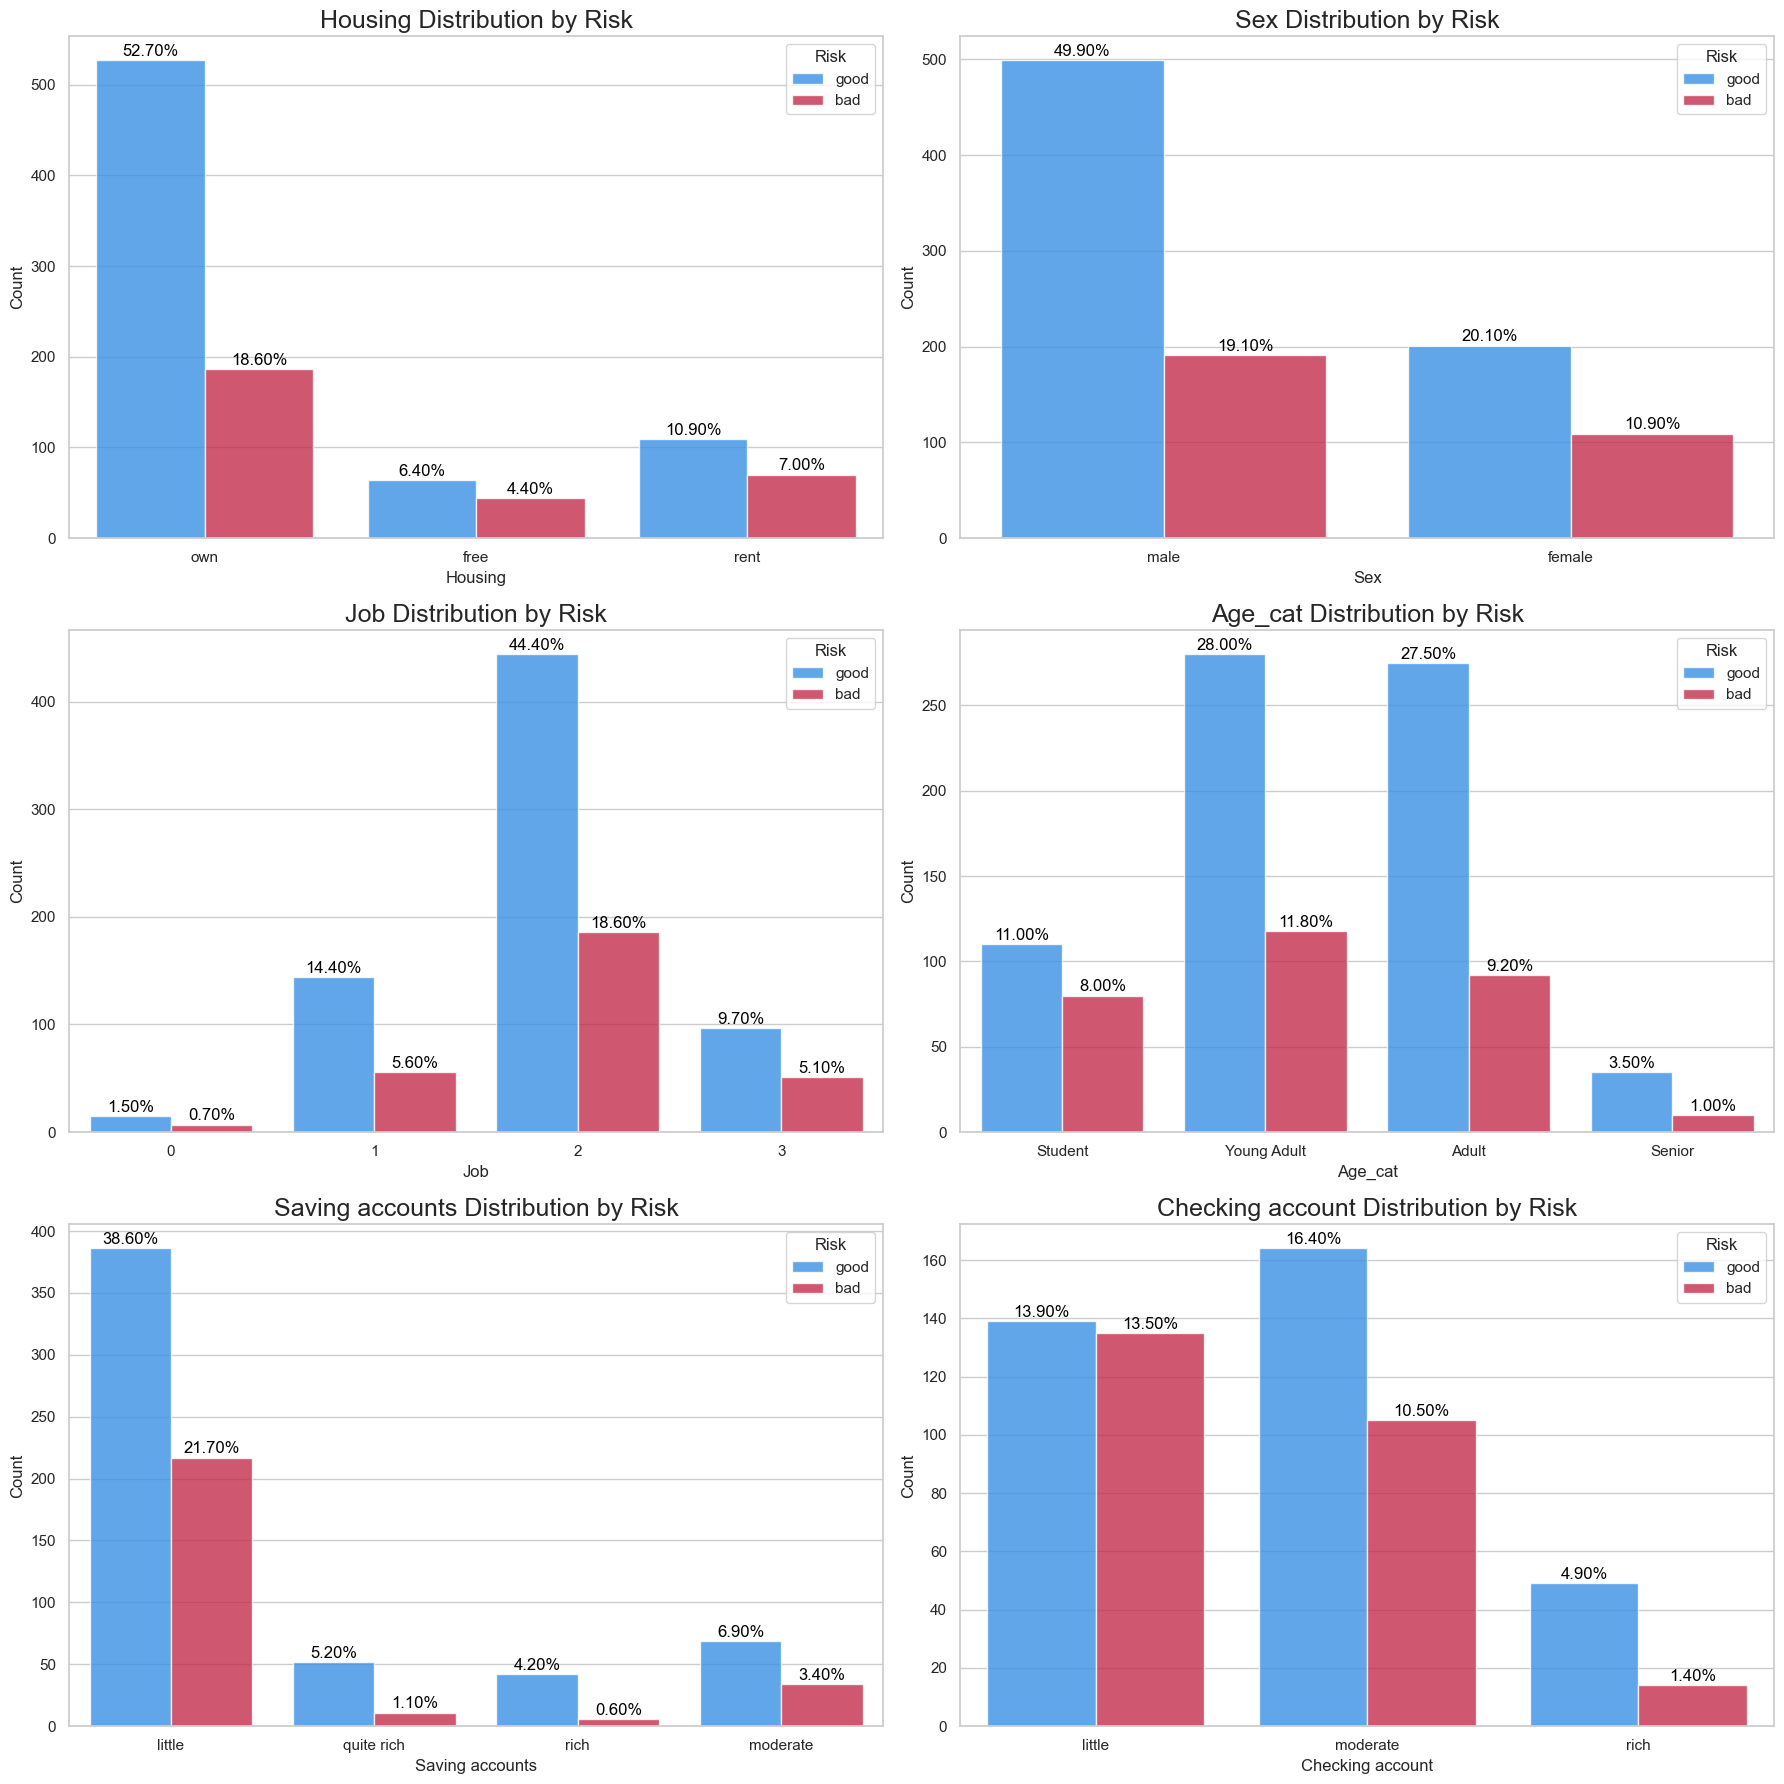

In [7]:
# Create a 3x2 grid of count plots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
# Columns to plot
columns_to_plot = ['Housing', 'Sex', 'Job', 'Age_cat', 'Saving accounts', 'Checking account']

# Loop through columns and create count plots
for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = sns.countplot(data=df, x=column, hue='Risk', alpha=0.8, palette={'good': 'dodgerblue', 'bad': 'crimson'}, ax=axes[row, col])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'{column} Distribution by Risk', fontsize=18)  
    
    # Add percentages on top of the bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height / len(df) * 100:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', fontsize=12, color='black')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend(title='Risk', loc='upper right')

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'categorical_var_vs_risk.png')
plt.savefig(plot_filename)
plt.show()

### Data Preprocessing & Feature Engineering/Transformation
#### Standarization of the numerical variables and one hot encoding of the categorical variables
#### Re-sampling due to the class imbalance

In [47]:
# Define categorical columns
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Age_cat', 'Job']

# Define numerical columns
numerical_columns = ['Age', 'Credit amount', 'Duration']

# Handling Nans w/ Imputation
imputer = SimpleImputer(strategy='most_frequent')
df['Saving accounts'] = imputer.fit_transform(df[['Saving accounts']])
df['Checking account'] = imputer.fit_transform(df[['Checking account']])
nan_count = df.isna().sum()
print(nan_count, "\n \n ... No more missing values \n")

#  One-Hot Encoding the Categorical Variables
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
print(df.head(1), "\n \n ...... Categorical variables are now one-hot encoded \n")

# Scaling the Numerical Variables
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
print(df[numerical_columns], "\n \n ......... Numerical variables are now scaled \n")

# Re-sampling Due to Class Imbalance
X = df.drop('Risk', axis=1) 
y = df['Risk']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['Risk'] = y_resampled
print(print(resampled_df['Risk'].value_counts()), "\n \n ............ Re-sampling applied to deal with class imbalance \n")

# Map 'Risk' to binary values in order to work with ML models
risk_mapping = {'bad': 0, 'good': 1}
resampled_df['Risk_num'] = resampled_df['Risk'].map(risk_mapping)
# Drop the original 'Risk' column to avoid entering into the model and overfitting
resampled_df.drop(columns=['Risk'], inplace=True)

# Rename dataframe for consitency with the code that follows
df_processed = resampled_df
df_processed.head()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
Age_cat             0
dtype: int64 
 
 ... No more missing values 

   Age  Credit amount  Duration  Risk  Sex_male  Housing_own  Housing_rent  \
0   67           1169         6  good         1            1             0   

   Saving accounts_moderate  Saving accounts_quite rich  Saving accounts_rich  \
0                         0                           0                     0   

   ...  Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
0  ...                            0                 1                0   

   Purpose_vacation/others  Age_cat_Young Adult  Age_cat_Adult  \
0                        0                    0              0   

   Age_cat_Senior  Job_1  Job_2  Job_3  
0               1      0      1      0  

[1 rows x 25 columns] 
 
 .

,Age,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,...,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Age_cat_Young Adult,Age_cat_Adult,Age_cat_Senior,Job_1,Job_2,Job_3,Risk_num
0,2.766456,-0.745131,-1.236478,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
1,-1.191404,0.949817,2.248194,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1.183312,-0.416562,-0.738668,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,0.831502,1.634247,1.750384,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,1.535122,0.566664,0.256953,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [53]:
print("Column Names:")
print(df_processed.columns)

Column Names:
Index(['Age', 'Credit amount', 'Duration', 'Sex_male', 'Housing_own',
       'Housing_rent', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Checking account_moderate', 'Checking account_rich', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Age_cat_Young Adult', 'Age_cat_Adult',
       'Age_cat_Senior', 'Job_1', 'Job_2', 'Job_3', 'Risk_num'],
      dtype='object')


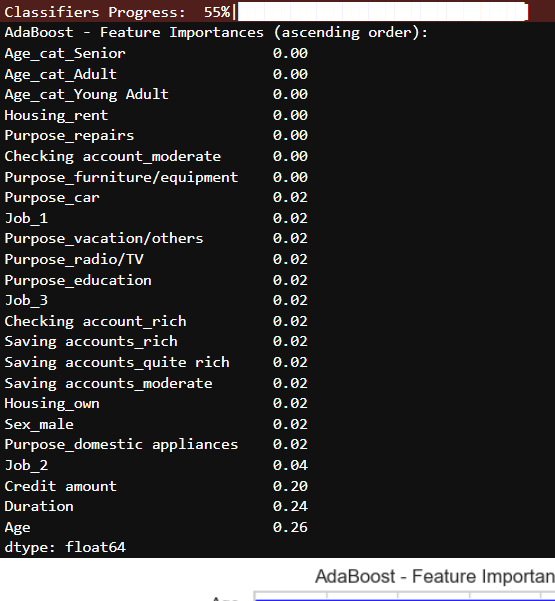

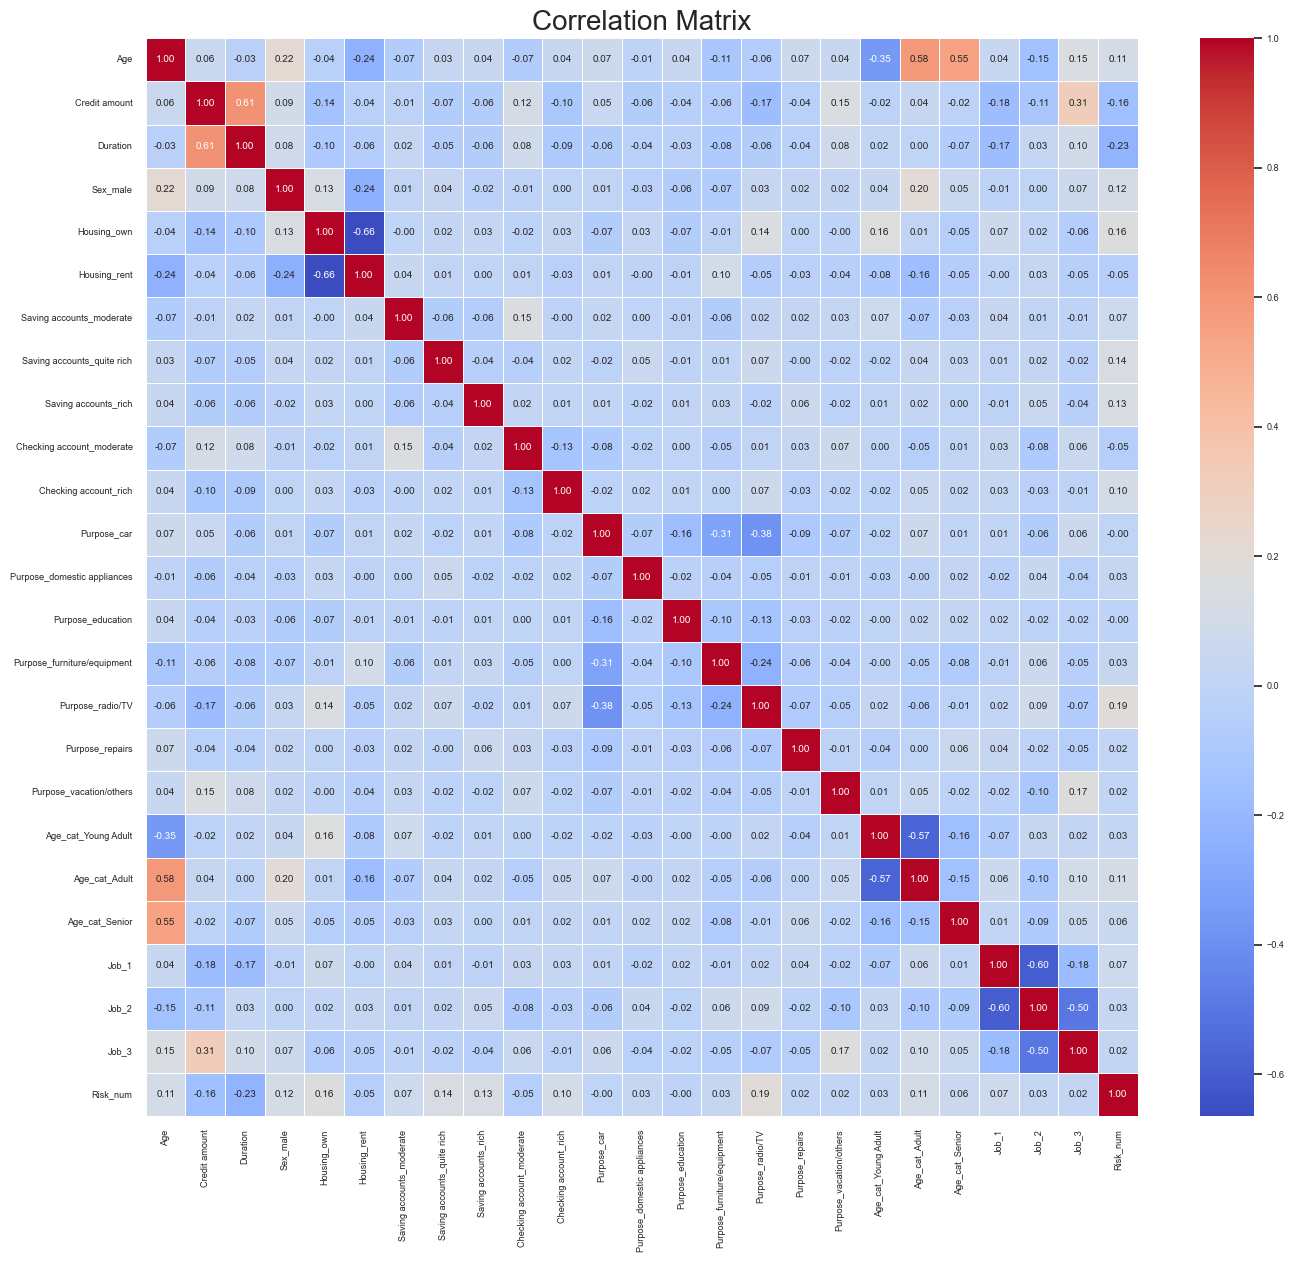

In [48]:
# Calculate the correlation matrix
correlation_matrix = resampled_df.corr()

# Set up the figure and axis for the heatmap
plt.figure(figsize=(16, 14))
sns.set(font_scale=0.6)  # Adjust the font scale if needed

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=20)

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'correlation_matrix_heatmap.png')
plt.savefig(plot_filename)
plt.show()

### Machine Learning Classifiers 

Class Distribution:
1    700
0    700
Name: Risk_num, dtype: int64


Classifiers Progress:   0%|                                                                     | 0/11 [00:00<?, ?it/s]

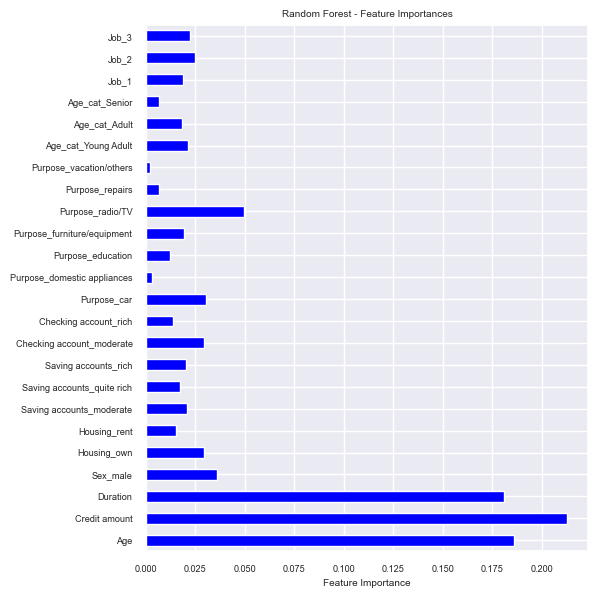

Classifiers Progress:   9%|█████▌                                                       | 1/11 [00:01<00:10,  1.02s/it]

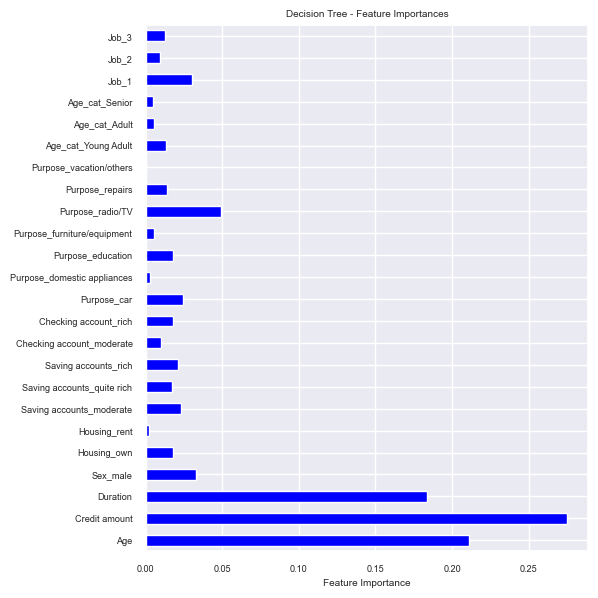

Classifiers Progress:  18%|███████████                                                  | 2/11 [00:01<00:07,  1.28it/s]

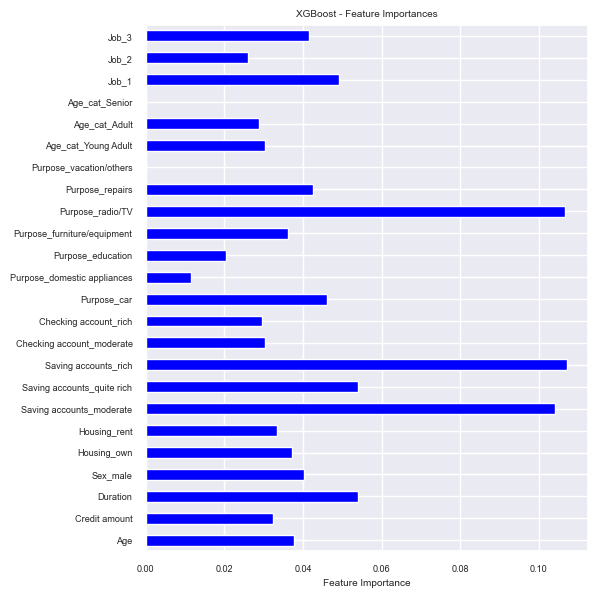

Classifiers Progress:  36%|██████████████████████▏                                      | 4/11 [00:06<00:13,  1.92s/it]

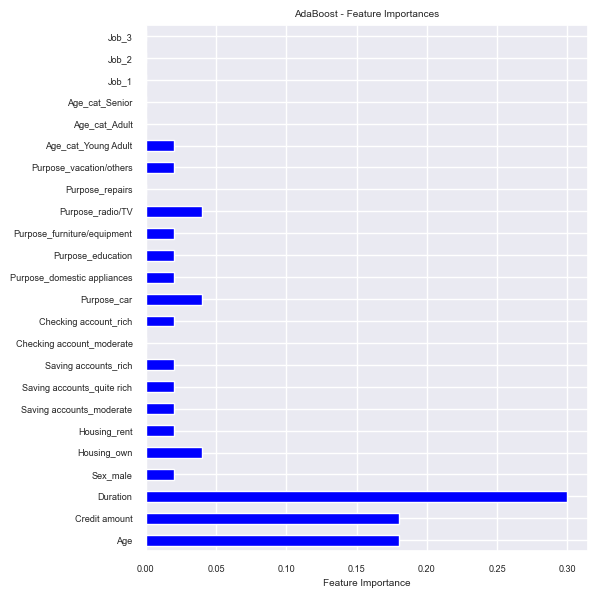

Classifiers Progress: 100%|████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]

Random Forest - Evaluation Metrics:
Accuracy: 0.7285714285714285
Precision: 0.7786259541984732
Sensitivity/Recall: 0.6845637583892618
Specificity: 0.7786259541984732
ROC AUC: 0.8203801424253293
Elapsed Time: 0.2995 seconds

Decision Tree - Evaluation Metrics:
Accuracy: 0.6321428571428571
Precision: 0.6691176470588235
Sensitivity/Recall: 0.610738255033557
Specificity: 0.6564885496183206
ROC AUC: 0.6336134023259389
Elapsed Time: 1.0336 seconds

XGBoost - Evaluation Metrics:
Accuracy: 0.7321428571428571
Precision: 0.7681159420289855
Sensitivity/Recall: 0.7114093959731543
Specificity: 0.7557251908396947
ROC AUC: 0.825042266509555
Elapsed Time: 2.8330 seconds

Neural Network - Evaluation Metrics:
Accuracy: 0.7071428571428572
Precision: 0.7445255474452555
Sensitivity/Recall: 0.6845637583892618
Specificity: 0.732824427480916
ROC AUC: 0.7668937957887187
Elapsed Time: 6.4684 seconds

Logistic Regression - Evaluation Metrics:
Accuracy: 0.6714285714285714
Precision: 0.7021276595744681
Sensitivity

In [49]:
# Declare target variable and predictor variables
X = df_processed.drop(columns=['Risk_num'])
y = df_processed['Risk_num']

# Check class balance
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'Random Forest': (RandomForestClassifier(random_state=42), {}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {}),
    'XGBoost': (XGBClassifier(random_state=42), {}),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100,), random_state=42), {}),
    'Logistic Regression': (LogisticRegression(random_state=42), {}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {}),
    'Naive Bayes': (GaussianNB(), {}),
    'Bagging Classifier': (BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42), {}),
    'Quadratic Discriminant Analysis': (QuadraticDiscriminantAnalysis(), {}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
}

# Initialize dictionaries to store results and ROC AUC scores
results = {}
roc_auc_scores = {}

# Define start_time before the loop
start_time = time.time()

for name, (classifier, _) in tqdm(classifiers.items(), desc='Classifiers Progress'):
    # Train and evaluate the classifier as before
    classifier.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Obtain predicted probabilities for the positive class
    y_pred_probs = classifier.predict_proba(X_test)[:, 1]
    
    threshold = 0.5  # You can adjust this threshold as needed

    # Adjust the threshold to convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_test, y_pred_probs)

    feature_importances = None
    if hasattr(classifier, 'feature_importances_'):
        feature_importances = pd.Series(classifier.feature_importances_, index=X.columns)
        
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity/Recall': recall,
        'Specificity': specificity,
        'ROC AUC': roc_auc,
        'Elapsed Time': elapsed_time,
        'Feature Importances': feature_importances,
        'y_pred_probs': y_pred_probs  # Store the predicted probabilities
    }
    
    # Store the ROC AUC score for later plotting
    roc_auc_scores[name] = roc_auc

    # Plot feature importances and save to the "plots" folder
    if feature_importances is not None:
        plt.figure(figsize=(6, 6))
        feature_importances.plot(kind='barh', color="blue")  # Use the same color for all plots
        plt.xlabel('Feature Importance')
        plt.title(f'{name} - Feature Importances')
        plt.tight_layout()
        
        # Save the plot to the "plots" folder
        plots_folder = 'plots'
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        plot_filename = os.path.join(plots_folder, f'{name}_feature_importance_plot.png')
        plt.savefig(plot_filename)
        plt.show()

# Print results without numerical values
for name, metrics in results.items():
    print(f"{name} - Evaluation Metrics:")
    for metric, value in metrics.items():
        if metric == 'Feature Importances' or metric == 'y_pred_probs':
            continue  # Skip printing feature importances and y_pred_probs
        if metric == 'Elapsed Time':
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value}")
    print()

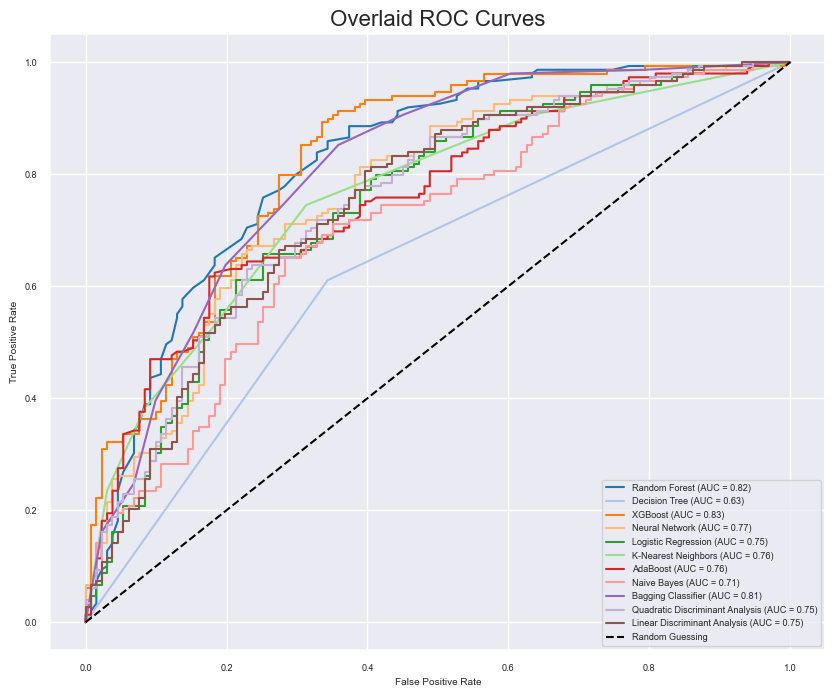

In [50]:
# Initialize an empty figure
plt.figure(figsize=(10, 8))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Plot the ROC curves for each model
for i, name in enumerate(roc_auc_scores.keys()):
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})', color=cmap(i))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overlaid ROC Curves', fontsize=16)
plt.legend()

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'overlaid_roc_curve.png')
plt.savefig(plot_filename)

# Show the plot
plt.show()

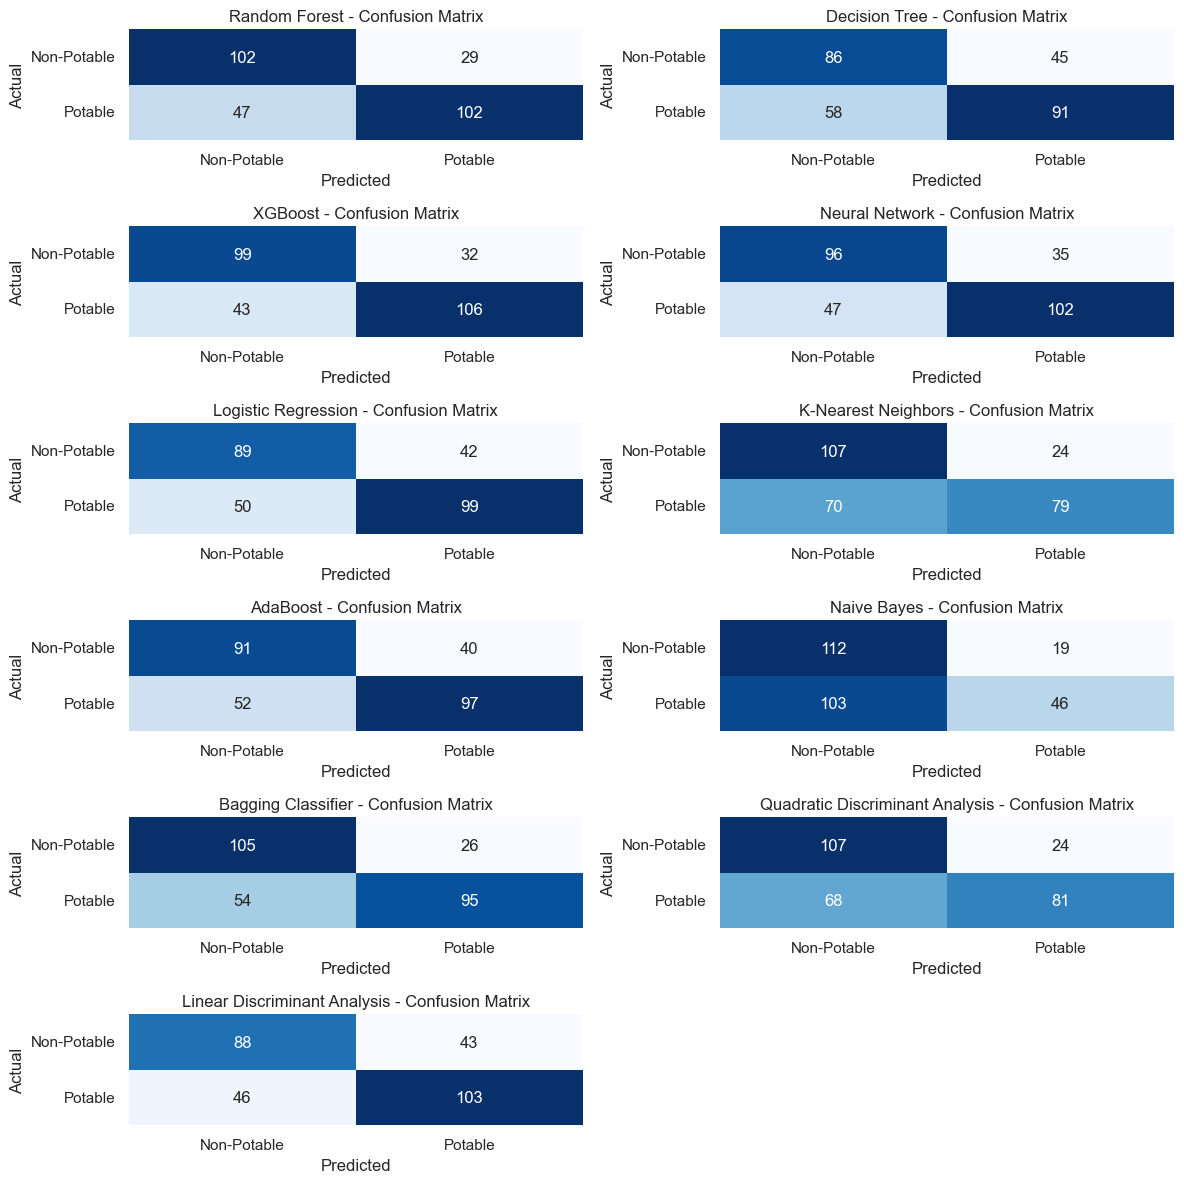

In [51]:
# Define the path to the plots folder
plots_folder = 'plots'

# Create the plots folder if it doesn't exist
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# Create a grid of confusion matrices
plt.figure(figsize=(12, 12))
grid_rows = len(classifiers) // 2 + len(classifiers) % 2
grid_cols = 2
sns.set(style="whitegrid")

for idx, (name, _) in enumerate(classifiers.items(), start=1):
    plt.subplot(grid_rows, grid_cols, idx)
    conf_matrix = confusion_matrix(y_test, results[name]['y_pred_probs'] > threshold)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Potable', 'Potable'], yticklabels=['Non-Potable', 'Potable'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()

# Save the combined plot
combined_plot_filename = os.path.join(plots_folder, 'confusion_matrix_combined.png')
plt.savefig(combined_plot_filename)
plt.show()

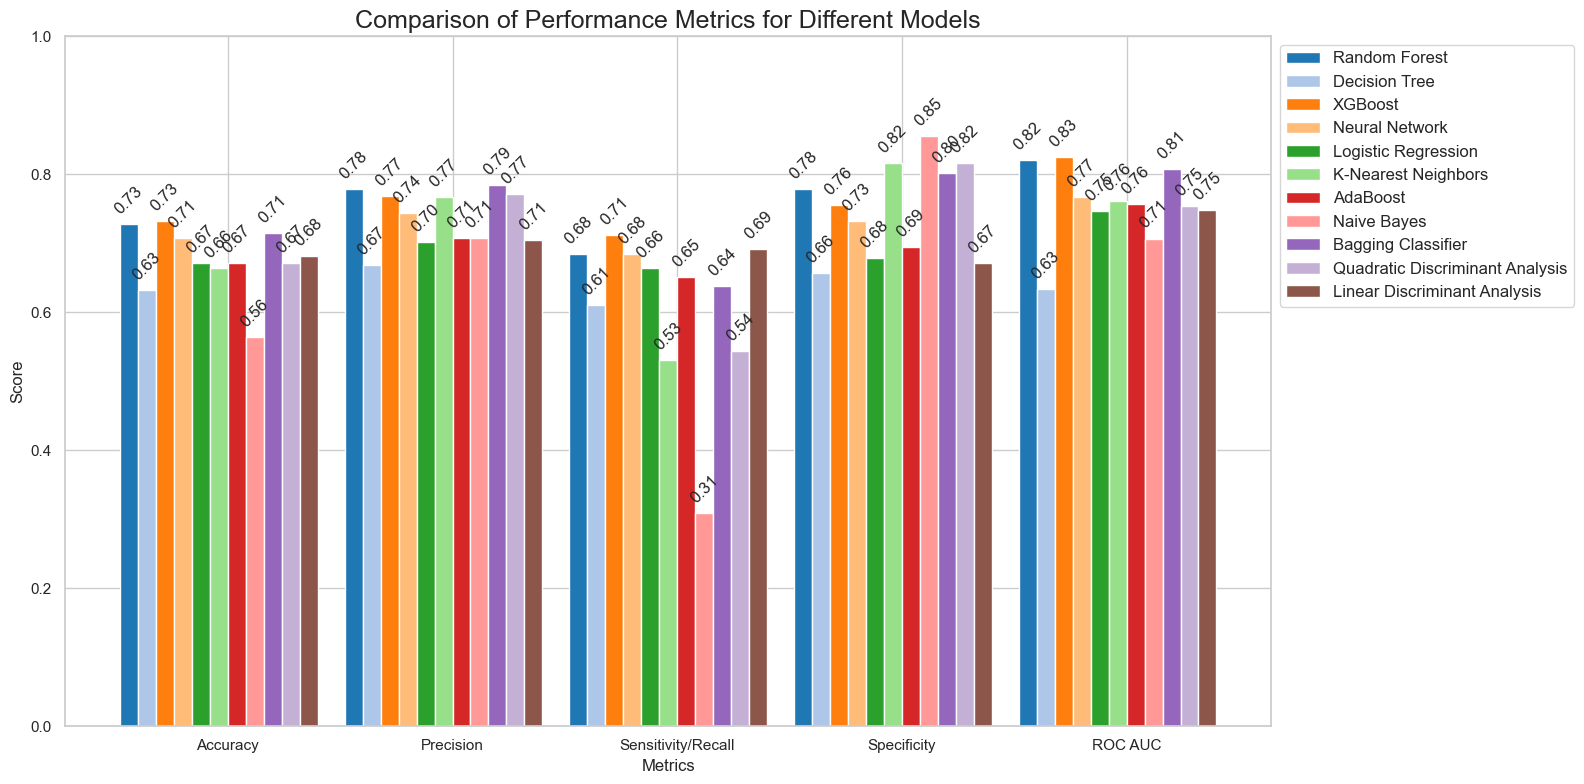

In [52]:
# List of metrics to include in the bar plot
metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity/Recall', 'Specificity', 'ROC AUC']

# Initialize a figure and axis
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Define the width of each group of bars
bar_width = 0.08

# Create an array of x positions for each set of bars
x_positions = np.arange(len(metrics_to_plot))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Iterate through each classifier and plot the metrics
for i, (name, metrics) in enumerate(results.items()):
    values = [metrics[metric] for metric in metrics_to_plot]
    x = x_positions + i * bar_width
    
    bars = ax.bar(x, values, width=bar_width, align='center', label=name, color=cmap(i))
    
    # Add metric values on top of each bar with rotation
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
                ha='center', va='bottom', rotation=45) 

# Configure plot settings
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Performance Metrics for Different Models', fontsize=18)
ax.set_xticks(x_positions + bar_width * len(results) / 2)
ax.set_xticklabels(metrics_to_plot)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 12})  
ax.set_ylim(0, 1)

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'performance_metrics_comparison.png')
plt.savefig(plot_filename)
plt.tight_layout()
plt.show()

In [ ]:
# Most impactful features from initial XGBoost testing
# top_features = ['Duration', 
#                 'Job', 
#                 'Age_cat_Senior', 
#                 'Age_cat_Student',
#                 'Checking account_moderate', 
#                 'Checking account_little', 
#                 'Purpose_business', 
#                 'Saving accounts_rich', 
#                 'Saving accounts_moderate', 
#                 'Housing_rent']

top_features = ['Age_cat_Student', 'Checking account_moderate', 'Checking account_little']

# Declare target variable and predictor variables
X = df_processed[top_features]  # Use only the top 10 features
y = df_processed['Risk_num']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Train the XGBoost classifier
start_time = time.time()
xgb_classifier.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

# Obtain predicted probabilities for the positive class
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]

threshold = 0.5  # You can adjust this threshold as needed

# Adjust the threshold to convert probabilities to binary predictions
y_pred = (y_pred_probs > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Print evaluation metrics
print("XGBoost with Most Impactful Features - Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Sensitivity/Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"ROC AUC: {roc_auc}")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

### Use PCA transformed features as predictors

In [ ]:
# Apply PCA to the resampled data
pca = PCA(n_components=10)  # Choose the number of components you want to retain
X_pca = pca.fit_transform(X_resampled)

# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Create a figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the Scree plot with dots and a line (ax1)
scree_plot = ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Scree Plot', color='b')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color='b')
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a second y-axis for the Cumulative Explained Variance plot (ax2)
ax2 = ax1.twinx()
cumulative_plot = ax2.bar(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, alpha=0.5, label='Cumulative Explained Variance', color='r')
ax2.set_ylabel('Cumulative Explained Variance Ratio', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine the legend handles and labels from both axes (ax1 and ax2)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

# Move the legend to the top middle of the plot
legend = ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1))

# Add text annotations for the Scree plot values and print them
scree_values = [f'{value:.2f}' for value in explained_variance_ratio]
for i, value in enumerate(explained_variance_ratio):
    ax1.annotate(f'{value:.2f}', (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
    print(f'Scree Plot - Component {i + 1}: {scree_values[i]}')

# Add text annotations for the Cumulative Explained Variance values and print them
cumulative_values = [f'{value:.2f}' for value in cumulative_variance_ratio]
for i, value in enumerate(cumulative_variance_ratio):
    ax2.annotate(f'{value:.2f}', (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
    print(f'Cumulative Explained Variance - Component {i + 1}: {cumulative_values[i]}')

# Adjust layout and show the combined plot
fig.tight_layout()
plt.show()

# Split the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

# Initialize classifiers for PCA-transformed data
classifiers_pca = {
    'Random Forest': (RandomForestClassifier(random_state=42), {}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {}),
    'XGBoost': (XGBClassifier(random_state=42), {}),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100,), random_state=42), {}),
    'Logistic Regression': (LogisticRegression(random_state=42), {}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {}),
    'Naive Bayes': (GaussianNB(), {}),
    'Bagging Classifier': (BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42), {}),
    'Quadratic Discriminant Analysis': (QuadraticDiscriminantAnalysis(), {}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
}

# Initialize dictionaries to store results and ROC AUC scores for PCA-transformed data
results_pca = {}
roc_auc_scores_pca = {}

# Define start_time before the loop for PCA-transformed data
start_time_pca = time.time()

for name, (classifier, _) in tqdm(classifiers_pca.items(), desc='Classifiers Progress (PCA)'):
    # Train and evaluate the classifier on PCA-transformed data
    classifier.fit(X_train_pca, y_train_pca)
    end_time_pca = time.time()
    elapsed_time_pca = end_time_pca - start_time_pca

    # Obtain predicted probabilities for the positive class
    y_pred_probs_pca = classifier.predict_proba(X_test_pca)[:, 1]

    threshold = 0.5  # You can adjust this threshold as needed

    # Adjust the threshold to convert probabilities to binary predictions
    y_pred_pca = (y_pred_probs_pca > threshold).astype(int)

    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    precision_pca = precision_score(y_test_pca, y_pred_pca)
    recall_pca = recall_score(y_test_pca, y_pred_pca)
    conf_matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
    tn_pca, fp_pca, fn_pca, tp_pca = conf_matrix_pca.ravel()
    specificity_pca = tn_pca / (tn_pca + fp_pca)
    roc_auc_pca = roc_auc_score(y_test_pca, y_pred_probs_pca)

    feature_importances_pca = None
    if hasattr(classifier, 'feature_importances_'):
        feature_importances_pca = pd.Series(classifier.feature_importances_, index=range(1, X_pca.shape[1] + 1))

    results_pca[name] = {
        'Accuracy': accuracy_pca,
        'Precision': precision_pca,
        'Sensitivity/Recall': recall_pca,
        'Specificity': specificity_pca,
        'ROC AUC': roc_auc_pca,
        'Elapsed Time': elapsed_time_pca,
        'Feature Importances': feature_importances_pca,
        'y_pred_probs': y_pred_probs_pca  # Store the predicted probabilities
    }

    # Store the ROC AUC score for later plotting
    roc_auc_scores_pca[name] = roc_auc_pca

# Print results without numerical values for PCA-transformed data
for name, metrics in results_pca.items():
    print(f"{name} - Evaluation Metrics (PCA):")
    for metric, value in metrics.items():
        if metric == 'Feature Importances' or metric == 'y_pred_probs':
            continue  # Skip printing feature importances and y_pred_probs
        if metric == 'Elapsed Time':
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value}")
    print()


### The analysis of the Scree plot and Cumulative Explained Variance plot reveals valuable insights into the use of PCA analysis and dimensionality reduction for building a classification model to predict credit risk. The Scree plot demonstrates that the explained variance sharply decreases after the first few principal components, indicating that the majority of the data's variance can be captured by retaining only a subset of components. The Cumulative Explained Variance plot reinforces this trend, showing that by including the first four components, we explain 40% of the total variance, and by the tenth component, 71%.

### From a technical perspective, this suggests that employing PCA for dimensionality reduction can be advantageous. By selecting the most informative principal components, we can significantly reduce the feature space while maintaining a substantial portion of the data's variance. This reduction in dimensionality can lead to more efficient model training and potentially enhanced model generalization.

### However, it's important to consider the trade-offs. Using all original features might yield slightly higher model accuracy, but it can also introduce challenges related to high dimensionality, such as increased computational complexity and a higher risk of overfitting. In the context of predicting credit risk, where model interpretability and computational efficiency are essential, the use of PCA aligns well with these objectives. It strikes a balance between model accuracy and practicality, allowing for explainable and reliable credit risk assessments while discarding less informative dimensions. Ultimately, the choice of whether to use PCA should be tailored to the specific business needs and the desired trade-offs between accuracy, efficiency, and interpretability.

### Dimensionality reduction methods like Principal Component Analysis (PCA) offer distinct advantages over conventional feature importance techniques, such as those utilized in Random Forest or ensemble models. A key strength lies in their potential for enhanced efficiency and reduced bias during feature selection. PCA objectively identifies and selects informative principal components based on the variance they capture, avoiding the subjectivity and potential biases inherent in traditional feature selection methods. This objectivity is particularly valuable when dealing with complex datasets where human-driven feature selection may introduce confirmation biases or domain-specific assumptions. Moreover, PCA significantly reduces dimensionality, leading to more efficient model training, while its handling of multicollinearity enhances model stability. In the context of credit risk prediction or other data-driven tasks, PCA's objectivity and efficiency contribute to transparent and fair model building, ensuring that feature selection remains data-driven rather than influenced by subjective judgments or biases. This approach ultimately bolsters the reliability and credibility of the model's predictions, aligning with best practices for responsible AI and data science.

In [ ]:
# Initialize an empty figure for ROC curves
plt.figure(figsize=(10, 8))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Plot the ROC curves for each model on PCA-transformed data
for i, name in enumerate(roc_auc_scores_pca.keys()):
    fpr, tpr, _ = roc_curve(y_test_pca, results_pca[name]['y_pred_probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores_pca[name]:.2f})', color=cmap(i))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overlaid ROC Curves (PCA-transformed Data)', fontsize=16)
plt.legend()

# Save the plot to the "plots_pca" folder
plots_folder_pca = 'plots_pca'
if not os.path.exists(plots_folder_pca):
    os.makedirs(plots_folder_pca)
plot_filename_pca = os.path.join(plots_folder_pca, 'overlaid_roc_curve_pca.png')
plt.savefig(plot_filename_pca)

# Show the plot
plt.show()

# Create a grid of confusion matrices for PCA-transformed data
plt.figure(figsize=(12, 12))
grid_rows = len(classifiers_pca) // 2 + len(classifiers_pca) % 2
grid_cols = 2
sns.set(style="whitegrid")

for idx, (name, _) in enumerate(classifiers_pca.items(), start=1):
    plt.subplot(grid_rows, grid_cols, idx)
    conf_matrix_pca = confusion_matrix(y_test_pca, results_pca[name]['y_pred_probs'] > threshold)
    sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Potable', 'Potable'], yticklabels=['Non-Potable', 'Potable'])
    plt.title(f'{name} - Confusion Matrix (PCA-transformed Data)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()

# Save the combined plot for PCA-transformed data
combined_plot_filename_pca = os.path.join(plots_folder_pca, 'confusion_matrix_combined_pca.png')
plt.savefig(combined_plot_filename_pca)
plt.show()

# List of metrics to include in the bar plot for PCA-transformed data
metrics_to_plot_pca = ['Accuracy', 'Precision', 'Sensitivity/Recall', 'Specificity', 'ROC AUC']

# Initialize a figure and axis for PCA-transformed data
plt.figure(figsize=(16, 8))
ax_pca = plt.gca()

# Create an array of x positions for each set of bars
x_positions_pca = np.arange(len(metrics_to_plot_pca))

# Iterate through each classifier and plot the metrics for PCA-transformed data
for i, (name, metrics) in enumerate(results_pca.items()):
    values = [metrics[metric] for metric in metrics_to_plot_pca]
    x_pca = x_positions_pca + i * bar_width
    
    bars_pca = ax_pca.bar(x_pca, values, width=bar_width, align='center', label=name, color=cmap(i))
    
    # Add metric values on top of each bar with rotation
    for bar_pca, value in zip(bars_pca, values):
        ax_pca.text(bar_pca.get_x() + bar_pca.get_width() / 2, bar_pca.get_height() + 0.01, f'{value:.2f}',
                    ha='center', va='bottom', rotation=45) 

# Configure plot settings for PCA-transformed data
ax_pca.set_xlabel('Metrics')
ax_pca.set_ylabel('Score')
ax_pca.set_title('Comparison of Performance Metrics for Different Models (PCA-transformed Data)', fontsize=18)
ax_pca.set_xticks(x_positions_pca + bar_width * len(results_pca) / 2)
ax_pca.set_xticklabels(metrics_to_plot_pca)
ax_pca.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 12})  
ax_pca.set_ylim(0, 1)

# Save the plot to the "plots_pca" folder
plots_folder_pca = 'plots_pca'
if not os.path.exists(plots_folder_pca):
    os.makedirs(plots_folder_pca)
plot_filename_pca = os.path.join(plots_folder_pca, 'performance_metrics_comparison_pca.png')
plt.savefig(plot_filename_pca)

# Show the plot for PCA-transformed data
plt.tight_layout()
plt.show()

### The observed changes in model performance when using Principal Component Analysis (PCA) for feature transformation can be attributed to several factors, including the nature of the data and the characteristics of the classification algorithms. Notably, the increase in sensitivity to 1.0 (100%) when using PCA-transformed features suggests that PCA might have effectively separated the classes, making it easier for the models to correctly classify positive cases. However, this improvement in sensitivity comes at a cost, as the accuracy and precision of the models decrease due to the loss of some information during dimensionality reduction. In essence, PCA may emphasize the underlying patterns in the data that are relevant for classification, but it may also introduce noise or reduce the model's ability to distinguish between classes, leading to lower overall accuracy and precision.

### Moreover, the increase in ROC AUC for models like Naive Bayes, Quadratic Discriminant Analysis (QDA), and Linear Discriminant Analysis (LDA) indicates that these models excel at differentiating between positive and negative cases when using PCA-transformed features. This suggests that PCA has a more significant impact on these models' ability to discern class boundaries. On the other hand, models like Random Forest, Decision Tree, XGBoost, Neural Network, Logistic Regression, K-Nearest Neighbors, AdaBoost, and Bagging Classifier may not show significant changes or may even exhibit decreased performance when using PCA-transformed features. This divergence can be attributed to the specific characteristics of the data, as PCA works well when the underlying data structure aligns with lower-dimensional representation assumptions. The choice to use PCA or not should be made based on the trade-offs between sensitivity, accuracy, and precision, considering the specific problem and data characteristics. Additionally, optimizing hyperparameters and considering alternative feature engineering approaches may help fine-tune the models' performance when using PCA-transformed features.